# EGT209 - Data Engineering Project Analysis

In order to have derive better analysis for the data we collected using Arduino, we decided to implement a Machine Learning Model to help us predict the Temperature, Air Quality and the Humidity for the coming 2 weeks. In order to ensure the safety of the environment, we also decided to implement Isolation Forest to check for any anomalies in the data for Temperature, Air Quality and Humidity. 

## Data Cleaning

In [164]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import plotly.express as px
import plotly.figure_factory as ff 
import math


In [79]:
df = pd.read_csv('output_data.csv')

df

,id,clientID,topic,message,timestamp
0,12,23.1;62.9;18,t4g1,NaN,2024-07-09 13:00:18
1,13,23.1;62.8;23,t4g1,NaN,2024-07-09 13:00:34
2,14,23.1;62.8;23,t4g1,NaN,2024-07-09 13:00:48
3,15,23.1;62.7;23,t4g1,NaN,2024-07-09 13:01:04
4,16,23.0;63.2;23,t4g1,NaN,2024-07-09 13:01:19
...,...,...,...,...,...
1493,1505,t4g1:139,t4g1,31.3;48.5;42,2024-07-29 19:09:49
1494,1506,t4g1:139,t4g1,31.7;49.2;40,2024-07-29 19:19:49
1495,1507,t4g1:139,t4g1,31.9;49.5;40,2024-07-29 19:29:49
1496,1508,t4g1:139,t4g1,32.0;50.2;39,2024-07-29 19:39:51


In [80]:
# Set the 'id' column as the index of the dataset
df.set_index('id', inplace=True)

# Display the first few rows of the updated dataset
df.head()


,clientID,topic,message,timestamp
id,,,,
12,23.1;62.9;18,t4g1,NaN,2024-07-09 13:00:18
13,23.1;62.8;23,t4g1,NaN,2024-07-09 13:00:34
14,23.1;62.8;23,t4g1,NaN,2024-07-09 13:00:48
15,23.1;62.7;23,t4g1,NaN,2024-07-09 13:01:04
16,23.0;63.2;23,t4g1,NaN,2024-07-09 13:01:19


In [81]:
data_removed = df.drop(index=range(12,312))
df = data_removed

df

,clientID,topic,message,timestamp
id,,,,
312,t4g1:139,t4g1,23.9;69.1;24,2024-07-15 16:41:47
313,t4g1:139,t4g1,26.2;61.6;26,2024-07-15 17:07:16
314,t4g1:139,t4g1,26.9;59.5;27,2024-07-15 17:17:16
315,t4g1:139,t4g1,26.7;59.8;28,2024-07-15 17:27:17
316,t4g1:139,t4g1,26.6;60.2;28,2024-07-15 17:37:17
...,...,...,...,...
1505,t4g1:139,t4g1,31.3;48.5;42,2024-07-29 19:09:49
1506,t4g1:139,t4g1,31.7;49.2;40,2024-07-29 19:19:49
1507,t4g1:139,t4g1,31.9;49.5;40,2024-07-29 19:29:49


In [82]:
data_removed2 = df.drop(index=range(477,480))
df = data_removed2

df

,clientID,topic,message,timestamp
id,,,,
312,t4g1:139,t4g1,23.9;69.1;24,2024-07-15 16:41:47
313,t4g1:139,t4g1,26.2;61.6;26,2024-07-15 17:07:16
314,t4g1:139,t4g1,26.9;59.5;27,2024-07-15 17:17:16
315,t4g1:139,t4g1,26.7;59.8;28,2024-07-15 17:27:17
316,t4g1:139,t4g1,26.6;60.2;28,2024-07-15 17:37:17
...,...,...,...,...
1505,t4g1:139,t4g1,31.3;48.5;42,2024-07-29 19:09:49
1506,t4g1:139,t4g1,31.7;49.2;40,2024-07-29 19:19:49
1507,t4g1:139,t4g1,31.9;49.5;40,2024-07-29 19:29:49


In [83]:
split_client = df['message'].str.split(';', expand=True)
split_columns = ['temperature', 'air quality', 'humidity']

df = pd.concat([df, split_client], axis=1)

#drop columns

df = df.drop(columns=['clientID'])

df

,topic,message,timestamp,0,1,2
id,,,,,,
312,t4g1,23.9;69.1;24,2024-07-15 16:41:47,23.9,69.1,24
313,t4g1,26.2;61.6;26,2024-07-15 17:07:16,26.2,61.6,26
314,t4g1,26.9;59.5;27,2024-07-15 17:17:16,26.9,59.5,27
315,t4g1,26.7;59.8;28,2024-07-15 17:27:17,26.7,59.8,28
316,t4g1,26.6;60.2;28,2024-07-15 17:37:17,26.6,60.2,28
...,...,...,...,...,...,...
1505,t4g1,31.3;48.5;42,2024-07-29 19:09:49,31.3,48.5,42
1506,t4g1,31.7;49.2;40,2024-07-29 19:19:49,31.7,49.2,40
1507,t4g1,31.9;49.5;40,2024-07-29 19:29:49,31.9,49.5,40


In [84]:
# Renaming the columns
df = df.rename(columns={
    0: 'temperature',
    1: 'air_quality',
    2: 'humidity',
    
})

# Display the first few rows of the updated data
df



,topic,message,timestamp,temperature,air_quality,humidity
id,,,,,,
312,t4g1,23.9;69.1;24,2024-07-15 16:41:47,23.9,69.1,24
313,t4g1,26.2;61.6;26,2024-07-15 17:07:16,26.2,61.6,26
314,t4g1,26.9;59.5;27,2024-07-15 17:17:16,26.9,59.5,27
315,t4g1,26.7;59.8;28,2024-07-15 17:27:17,26.7,59.8,28
316,t4g1,26.6;60.2;28,2024-07-15 17:37:17,26.6,60.2,28
...,...,...,...,...,...,...
1505,t4g1,31.3;48.5;42,2024-07-29 19:09:49,31.3,48.5,42
1506,t4g1,31.7;49.2;40,2024-07-29 19:19:49,31.7,49.2,40
1507,t4g1,31.9;49.5;40,2024-07-29 19:29:49,31.9,49.5,40


In [85]:
#missing values 

nan_values = df.isnull().sum().sum()

print(f"The number of null values is {nan_values}")

The number of null values is 0


## Analysis

In [86]:
import plotly.express as px

# Define custom color sequences
temperature_color = ['#636EFA']  # Blue color for temperature
air_quality_color = ['#EF553B']  # Red color for air quality
humidity_color = ['#00CC96']  # Green color for humidity

# Temperature Distribution
fig_temp = px.histogram(df, x='temperature', nbins=20, title='Temperature Distribution',
                        color_discrete_sequence=temperature_color)
fig_temp.show()

# Air Quality Distribution
fig_air_quality = px.histogram(df, x='air_quality', nbins=20, title='Air Quality Distribution',
                               color_discrete_sequence=air_quality_color)
fig_air_quality.show()

# Humidity Distribution
fig_humidity = px.histogram(df, x='humidity', nbins=20, title='Humidity Distribution',
                            color_discrete_sequence=humidity_color)
fig_humidity.show()

1. Air Quality Distribution:

	• The air quality distribution shows a wide range of values, with certain peaks indicating more frequent occurrences of specific air quality levels. The frequent peaks suggest that the air quality is often in specific ranges, suggesting controlled environmental conditions or recurring events that affect air quality.

2. Humidity Distribution:

	• The humidity distribution appears to be bimodal, with two prominent peaks around the 38% and 42% humidity levels. This suggests that the factory environment typically operates within these two humidity levels, possibly due to specific operational settings or environmental controls. The presence of these two distinct peaks suggests a change in the environmental controls or in external conditions.

3. Temperature Distribution:

	• The temperature distribution also displays a trend with several peaks, particularly around 27°C and 28°C. This indicates that the temperature is frequently maintained within these ranges, possibly due to controlled heating or cooling processes. The distribution’s spread shows that the temperature varies but remains within a certain range, which could be critical for maintaining optimal operational conditions.

### Correlation Matrix

In [87]:
import plotly.graph_objects as go
import numpy as np

correlation_matrix = df[['temperature', 'air_quality', 'humidity']].corr()

fig_corr = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='Viridis'
))

fig_corr.update_layout(title='Correlation Matrix of Environmental Parameters')
fig_corr.show()


According to the above Correlation Matrix, we can derive the correlation matrix between the three targets 

1. Temperature - Air Quality: 
- The correlation between Temperature and Air Quality is around -0.5, showing a very strong negative correlation betweent the two, leading to the possibility that as temperature increases Air Quality decreases or vice versa. 
2. Temperature - Humidity:
- The correlation between Temperatue and Humidity is around 0, showing a moderare negative correlation between the two, indicating that higher temperature values may possibly lead to lower humidity levels. 
3. Air Quality - Humidity: 
- The correlation between Air Quality and Humidity is around -0.4, showing a weak negative correlation between the two, suggesting a change in humidity will have minimal impact on the Air Quality levels. 

### Getting the Average Values for every 3 Hours

In [88]:
import pandas as pd

# Assuming your data is loaded into df
print(df.columns)  # Check if 'timestamp' exists in the columns

# If 'timestamp' is the index, reset it
if 'timestamp' not in df.columns:
    df.reset_index(inplace=True)

# Now convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Continue with your processing as before
df = df[['timestamp', 'temperature', 'air_quality', 'humidity']]

df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['air_quality'] = pd.to_numeric(df['air_quality'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

df.set_index('timestamp', inplace=True)

resampled_df = df.resample('3H').mean().reset_index()

resampled_df.columns = ['timestamp', 'avg_temperature', 'avg_air_quality', 'avg_humidity']

print(resampled_df.head())


Index(['topic', 'message', 'timestamp', 'temperature', 'air_quality',
       'humidity'],
      dtype='object')
            timestamp  avg_temperature  avg_air_quality  avg_humidity
0 2024-07-15 15:00:00        26.200000        61.542857     26.714286
1 2024-07-15 18:00:00        26.488889        62.844444     28.333333
2 2024-07-15 21:00:00        27.122222        70.127778     30.444444
3 2024-07-16 00:00:00        27.294444        72.527778     30.000000
4 2024-07-16 03:00:00        27.311111        73.966667     31.111111


/var/folders/wv/lgt7rwvx5dn_v1y74zftwswh0000gn/T/ipykernel_55995/4056005030.py:22: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



## Machine Learning Models

For the second part of our analysis, we will utilise two models, LinearRegression Model and Isolation Forest

- **Linear Regression** will be used to predict the future temperature, air quality and humidity values to gain a better understanding of how the environment will change

- **Isolation Forest** will be used to identify anomalies in the data, which can be used to tell if there is any unusual patterns that could indicate safety hazards or equipment failures. 

### Linear Regression Model

In [89]:
# #converting 'timestamp to datetime format' 
df.index = pd.to_datetime(df.index)

df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.day_of_week
df['date'] = df.index.day
df['hour'] = df.index.hour

# data = df.drop(['topic', 'message', 'timestamp'], axis=1)

df['temperature'] = df['temperature'].astype('float')
df['air_quality'] = df['air_quality'].astype('float')
df['humidity'] = df['humidity'].astype('float')


print(f"The type of the column in the DataFrame")
print("\n")
print(df.dtypes)


The type of the column in the DataFrame


temperature    float64
air_quality    float64
humidity       float64
year             int32
month            int32
day_of_week      int32
date             int32
hour             int32
dtype: object


We now train the Linear Regression Model

In [90]:
df

,temperature,air_quality,humidity,year,month,day_of_week,date,hour
timestamp,,,,,,,,
2024-07-15 16:41:47,23.9,69.1,24.0,2024,7,0,15,16
2024-07-15 17:07:16,26.2,61.6,26.0,2024,7,0,15,17
2024-07-15 17:17:16,26.9,59.5,27.0,2024,7,0,15,17
2024-07-15 17:27:17,26.7,59.8,28.0,2024,7,0,15,17
2024-07-15 17:37:17,26.6,60.2,28.0,2024,7,0,15,17
...,...,...,...,...,...,...,...,...
2024-07-29 19:09:49,31.3,48.5,42.0,2024,7,0,29,19
2024-07-29 19:19:49,31.7,49.2,40.0,2024,7,0,29,19
2024-07-29 19:29:49,31.9,49.5,40.0,2024,7,0,29,19


In [91]:
features = ["day_of_week", "date", "month", "hour"] # declare the features the model will be training on

targets = ['temperature', 'air_quality', 'humidity']

#splitting of the sets 

X = df[features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



the data is split into three to improve the overall accuracy of the model. The Model will train on the train set and then will proceed onto test on the validation set. For its final testing, the model will then be tested on the final test set, where it tests on unseen data. This process will allow for more reliable accuracy of the model

In [92]:
#print the size of the test sets
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print("\n")
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print("\n")
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

X_train:  (956, 4)
y_train:  (956, 3)


X_test:  (120, 4)
y_test:  (120, 3)


X_val: (119, 4)
y_val: (119, 3)


In [93]:
#fitting and creating Linear Regression Model

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

#### Validating on the Validation Set:

In [94]:
#bringing out the predicted values the model had predicted

y_val_pred = model.predict(X_val)

y_val_pred

array([[31.64324271, 60.79060533, 41.0990894 ],
       [32.17990207, 55.48702817, 41.124424  ],
       [30.08236782, 61.33040296, 40.83813579],
       [30.92988768, 60.397557  , 40.97177942],
       [27.98702436, 59.7092932 , 40.45831705],
       [30.79791364, 54.25896675, 40.87191525],
       [32.13518046, 55.92899294, 41.12231278],
       [30.21653266, 60.00450867, 40.84446944],
       [24.36919799, 74.71959483, 35.0263868 ],
       [32.00101562, 57.25488723, 41.11597913],
       [29.45845602, 60.0534251 , 40.71504824],
       [31.77959835, 52.0002265 , 41.01189253],
       [24.45864121, 73.8356653 , 35.03060923],
       [28.745101  , 59.66037677, 40.58773825],
       [31.69015512, 52.88415603, 41.00767009],
       [29.90348136, 63.09826201, 40.82969092],
       [28.07646759, 58.82536367, 40.46253949],
       [31.956294  , 57.69685199, 41.11386792],
       [29.32429118, 61.37931939, 40.70871459],
       [31.82212916, 59.02274628, 41.10753427],
       [27.58452983, 63.68697607, 40.439

In [95]:
# For Temperature
temp_mse_val = mean_squared_error(y_val['temperature'], y_val_pred[:, 0])
temp_r2_val = r2_score(y_val['temperature'], y_val_pred[:, 0])


# For Air Quality
air_quality_mse_val = mean_squared_error(y_val['air_quality'], y_val_pred[:, 1])
air_quality_r2_val = r2_score(y_val['air_quality'], y_val_pred[:, 1])

# For Humidity
humidity_mse_val = mean_squared_error(y_val['humidity'], y_val_pred[:, 2])
humidity_r2_val = r2_score(y_val['humidity'], y_val_pred[:, 2])

# Display the results
print("Scores for Temperature: ")
print(f"MSE of the Validation Set: {temp_mse_val}")
print(f"R² of the Validation Set: {temp_r2_val}")
print("\n")
print("Scores for Air Quality: ")
print(f"MSE of the Validation Set: {air_quality_mse_val}")
print(f"R² of the Validation Set: {air_quality_r2_val}")
print("\n")
print("Scores for Humidity: ")
print(f"MSE of the Validation Set: {humidity_mse_val}")
print(f"R² of the Validation Set: {humidity_r2_val}")



Scores for Temperature: 
MSE of the Validation Set: 5.1729097242232935
R² of the Validation Set: 0.5199444682821912


Scores for Air Quality: 
MSE of the Validation Set: 27.087979344793855
R² of the Validation Set: 0.5113478630363313


Scores for Humidity: 
MSE of the Validation Set: 23.754430770864076
R² of the Validation Set: 0.19063540523700562


#### Testing on the Test Set:

In [96]:
#Test on the testing set

y_test_pred = model.predict(X_test)

y_test_pred

array([[28.56621454, 61.42823582, 40.57929339],
       [30.30597589, 59.12057914, 40.84869187],
       [24.86113574, 69.85798243, 35.04961018],
       [30.88735687, 53.37503722, 40.87613768],
       [29.86289859, 54.47113279, 45.71437935],
       [27.18422611, 60.2001744 , 40.32678464],
       [30.21653266, 60.00450867, 40.84446944],
       [29.81622893, 56.517707  , 40.73193797],
       [29.54789925, 59.16949557, 40.71927067],
       [27.13950449, 60.64213916, 40.32467342],
       [28.83454422, 58.77644724, 40.59196069],
       [30.84263525, 53.81700199, 40.87402646],
       [27.58452983, 63.68697607, 40.43931611],
       [31.15349575, 58.18773318, 40.9823355 ],
       [28.96870907, 57.45055295, 40.59829433],
       [27.89758113, 60.59322273, 40.45409462],
       [27.36092176, 65.89679988, 40.42876003],
       [28.87926584, 58.33448248, 40.5940719 ],
       [32.00101562, 57.25488723, 41.11597913],
       [28.20844163, 64.96395392, 40.56240366],
       [30.3506975 , 58.67861438, 40.850

In [97]:
temp_mse_val = mean_squared_error(y_test['temperature'], y_test_pred[:, 0])
temp_r2_val = r2_score(y_test['temperature'], y_test_pred[:, 0])


# For Air Quality
air_quality_mse_val = mean_squared_error(y_test['air_quality'], y_test_pred[:, 1])
air_quality_r2_val = r2_score(y_test['air_quality'], y_test_pred[:, 1])

# For Humidity
humidity_mse_val = mean_squared_error(y_test['humidity'], y_test_pred[:, 2])
humidity_r2_val = r2_score(y_test['humidity'], y_test_pred[:, 2])

# Display the results
print("Scores for Temperature: ")
print(f"MSE of the Test Set: {temp_mse_val}")
print(f"R² of the Test Set: {temp_r2_val}")
print("\n")
print("Scores for Air Quality: ")
print(f"MSE of the Test Set: {air_quality_mse_val}")
print(f"R² of the Test Set: {air_quality_r2_val}")
print("\n")
print("Scores for Humidity: ")
print(f"MSE of the Tets Set: {humidity_mse_val}")
print(f"R² of the Test Set: {humidity_r2_val}")

Scores for Temperature: 
MSE of the Test Set: 4.688817096891414
R² of the Test Set: 0.48474851958140996


Scores for Air Quality: 
MSE of the Test Set: 33.098748764541476
R² of the Test Set: 0.3981078927975322


Scores for Humidity: 
MSE of the Tets Set: 13.75376297400212
R² of the Test Set: 0.24093612643912266


### Fine tuning Round 1:

For the first round of fune tuning, we can use GridSearchCV to get the best parameters possible for the Linear Regression Model

In [98]:
param_grid = {
    'fit_intercept': [True, False],
}
    
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Best Cross-Validation R² Score: {best_score}")

# Use the best estimator to make predictions
best_lr_model = grid_search.best_estimator_
y_val_pred = best_lr_model.predict(X_val)

# Evaluate on the validation set
temp_mse_val = mean_squared_error(y_val['temperature'], y_val_pred[:, 0])
temp_r2_val = r2_score(y_val['temperature'], y_val_pred[:, 0])

air_quality_mse_val = mean_squared_error(y_val['air_quality'], y_val_pred[:, 1])
air_quality_r2_val = r2_score(y_val['air_quality'], y_val_pred[:, 1])

# For Humidity
humidity_mse_val = mean_squared_error(y_val['humidity'], y_val_pred[:, 2])
humidity_r2_val = r2_score(y_val['humidity'], y_val_pred[:, 2])

# Display the results
print("Scores after GridSearchCV:")
print("Scores for Temperature: ")
print(f"MSE of the Validation Set: {temp_mse_val}")
print(f"R² of the Validation Set: {temp_r2_val}")
print("\n")
print("Scores for Air Quality: ")
print(f"MSE of the Validation Set: {air_quality_mse_val}")
print(f"R² of the Validation Set: {air_quality_r2_val}")
print("\n")
print("Scores for Humidity: ")
print(f"MSE of the Validation Set: {humidity_mse_val}")
print(f"R² of the Validation Set: {humidity_r2_val}")



Scores after GridSearchCV:
Scores for Temperature: 
MSE of the Validation Set: 5.1729097242232935
R² of the Validation Set: 0.5199444682821912


Scores for Air Quality: 
MSE of the Validation Set: 27.087979344793855
R² of the Validation Set: 0.5113478630363313


Scores for Humidity: 
MSE of the Validation Set: 23.754430770864076
R² of the Validation Set: 0.19063540523700562


### Fine Tuning Round 2:

{'fit': {'sample_weight': None}, 'score': {'sample_weight': None}}

In [116]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # Set up the pipeline with a standard scaler and a ridge regression model
# ridge_pipeline = Pipeline([
#     ('scaler', StandardScaler()),   # Standardizes the data
#     ('ridge', Ridge())              # Applies Ridge Regression
# ])

# # Set up the pipeline with a standard scaler and a lasso regression model
# lasso_pipeline = Pipeline([
#     ('scaler', StandardScaler()),   # Standardizes the data
#     ('lasso', Lasso())              # Applies Lasso Regression
# ])

# # Define the hyperparameters to tune
# ridge_params = {
#     'ridge__alpha': [0.1, 1.0, 10.0, 100.0]  # Ridge regularization strength
# }

# lasso_params = {
#     'lasso__alpha': [0.1, 1.0, 10.0, 100.0]  # Lasso regularization strength
# }

# # Use the pipeline in GridSearchCV
# ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5)
# ridge_grid.fit(X_train, y_train)

# lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5)
# lasso_grid.fit(X_train, y_train)

# # Predictions on the validation set for Ridge
# y_val_pred_ridge = ridge_grid.predict(X_val)

# # Predictions on the validation set for Lasso
# y_val_pred_lasso = lasso_grid.predict(X_val)

# # Calculate validation metrics for Ridge(Temp)
# temp_mse_val_ridge = mean_squared_error(y_val['temperature'], y_val_pred_ridge[:, 0])
# temp_r2_val_ridge = r2_score(y_val['temperature'], y_val_pred_ridge[:, 0])

# # Calculate validation metrics for Lasso(Temp)
# temp_mse_val_lasso = mean_squared_error(y_val['temperature'], y_val_pred_lasso[:, 0])
# temp_r2_val_lasso = r2_score(y_val['temperature'], y_val_pred_lasso[:, 0])

# # Calculate validation metrics for Ridge(AQ)
# aq_mse_val_ridge = mean_squared_error(y_val['air_quality'], y_val_pred_ridge[:, 1])
# aq_r2_val_ridge = r2_score(y_val['air_quality'], y_val_pred_ridge[:, 1])

# # Calculate validation metrics for Lasso(AQ)
# aq_mse_val_lasso = mean_squared_error(y_val['air_quality'], y_val_pred_lasso[:, 1])
# aq_r2_val_lasso = r2_score(y_val['air_quality'], y_val_pred_lasso[:, 1])

# # Calculate validation metrics for Ridge(humidity)
# hum_mse_val_ridge = mean_squared_error(y_val['humidity'], y_val_pred_ridge[:, 2])
# hum_r2_val_ridge = r2_score(y_val['humidity'], y_val_pred_ridge[:, 2])

# # Calculate validation metrics for Lasso(humidity)
# hum_mse_val_lasso = mean_squared_error(y_val['humidity'], y_val_pred_lasso[:, 2])
# hum_r2_val_lasso = r2_score(y_val['humidity'], y_val_pred_lasso[:, 2])

# print("For Temperature:")
# print(f"Ridge Validation MSE: {temp_mse_val_ridge}")
# print(f"Ridge Validation R²: {temp_r2_val_ridge}")
# print(f"Lasso Validation MSE: {temp_mse_val_lasso}")
# print(f"Lasso Validation R²: {temp_r2_val_lasso}")
# print("\n")
# print("For Air Quality:")
# print(f"Ridge Validation MSE: {aq_mse_val_ridge}")
# print(f"Ridge Validation R²: {aq_r2_val_ridge}")
# print(f"Lasso Validation MSE: {aq_mse_val_lasso}")
# print(f"Lasso Validation R²: {aq_r2_val_lasso}")
# print("\n")
# print("For Humidity:")
# print(f"Ridge Validation MSE: {hum_mse_val_ridge}")
# print(f"Ridge Validation R²: {hum_r2_val_ridge}")
# print(f"Lasso Validation MSE: {hum_mse_val_lasso}")
# print(f"Lasso Validation R²: {hum_r2_val_lasso}")

# # Select the best model from the validation performance
# best_model = ridge_grid.best_estimator_ if temp_r2_val_ridge > temp_r2_val_lasso else lasso_grid.best_estimator_

# # Predictions on the test set
# y_test_pred = best_model.predict(X_test)

# # Calculate test metrics
# temp_mse_test = mean_squared_error(y_test['temperature'], y_test_pred[:, 0])
# temp_r2_test = r2_score(y_test['temperature'], y_test_pred[:, 0])
# aq_mse_test = mean_squared_error(y_test['air_quality'], y_test_pred[:, 1])
# aq_r2_test = r2_score(y_test['air_quality'], y_test_pred[:, 1])
# hum_mse_test = mean_squared_error(y_test['humidity'], y_test_pred[:, 2])
# hum_r2_test = r2_score(y_test['humidity'], y_test_pred[:, 2])

# print("\n")
# print(f"Test MSE (Temperature): {temp_mse_test}")
# print(f"Test R² (Temperature): {temp_r2_test}")
# print(f"Test RMSE (Temperature): {math.sqrt(temp_mse_test)}")
# print("\n")
# print(f"Test MSE (Air Quality): {aq_mse_test}")
# print(f"Test R² (Air Quality): {aq_r2_test}")
# print(f"Test RMSE (Air Quality): {math.sqrt(aq_mse_test)}")
# print("\n")
# print(f"Test MSE (Humidity): {hum_mse_test}")
# print(f"Test R² (Humidity): {hum_r2_test}")
# print(f"Test RMSE (Humidity): {math.sqrt(hum_mse_test)}")

#### Fine Tuning Round 3 (Feature Engineering):

Using Gradient Boosting on top of Linear Regression

In [120]:
#defining Gradient Boosting 
gradient_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

stacked_model = StackingRegressor(
    estimators = [('gradient_model', gradient_model), ('model', model)],
    final_estimator= LinearRegression()

)
    


In [128]:
#wrap it in a multi output regressor 

multi_output_stacked_model = MultiOutputRegressor(stacked_model)

# Train the model
multi_output_stacked_model.fit(X_train, y_train)

# Predict on the validation set
stacked_val_pred = multi_output_stacked_model.predict(X_val)

In [129]:
stacked_val_pred

array([[33.08746654, 55.01934792, 40.96603983],
       [34.46245834, 52.28999443, 39.36127117],
       [27.15922809, 72.19292044, 42.20876914],
       [31.73191632, 59.30781437, 37.6988119 ],
       [26.97144061, 60.1197264 , 44.06136101],
       [31.52328951, 53.02446888, 38.44201631],
       [33.75745173, 54.6918741 , 40.14774594],
       [25.50349084, 61.07206364, 47.75396035],
       [27.34396549, 71.81027991, 30.63578702],
       [32.76947857, 56.44881468, 40.18568175],
       [25.35233245, 59.47922808, 45.42641079],
       [33.65337625, 54.8578843 , 40.43555939],
       [27.3447292 , 73.27288045, 30.70526268],
       [26.5853406 , 59.35889854, 43.45397931],
       [33.80606986, 53.56608834, 40.22989763],
       [27.16930298, 70.41991471, 42.6634504 ],
       [27.59921718, 66.31362052, 39.04638216],
       [32.81494612, 57.78380212, 40.07389044],
       [25.0415492 , 60.72269501, 45.54428755],
       [33.01689692, 57.31116331, 41.05173872],
       [25.19157464, 59.16215596, 46.730

In [130]:
# For Temperature
temp_mse_val = mean_squared_error(y_val['temperature'], stacked_val_pred[:, 0])
temp_r2_val = r2_score(y_val['temperature'], stacked_val_pred[:, 0])


# For Air Quality
air_quality_mse_val = mean_squared_error(y_val['air_quality'], stacked_val_pred[:, 1])
air_quality_r2_val = r2_score(y_val['air_quality'], stacked_val_pred[:, 1])

# For Humidity
humidity_mse_val = mean_squared_error(y_val['humidity'], stacked_val_pred[:, 2])
humidity_r2_val = r2_score(y_val['humidity'], stacked_val_pred[:, 2])

# Display the results
print("Scores for Temperature: ")
print(f"MSE of the Validation Set: {temp_mse_val}")
print(f"R² of the Validation Set: {temp_r2_val}")
print("\n")
print("Scores for Air Quality: ")
print(f"MSE of the Validation Set: {air_quality_mse_val}")
print(f"R² of the Validation Set: {air_quality_r2_val}")
print("\n")
print("Scores for Humidity: ")
print(f"MSE of the Validation Set: {humidity_mse_val}")
print(f"R² of the Validation Set: {humidity_r2_val}")

Scores for Temperature: 
MSE of the Validation Set: 0.05521660596881631
R² of the Validation Set: 0.9948757974619414


Scores for Air Quality: 
MSE of the Validation Set: 1.216809993771491
R² of the Validation Set: 0.9780494219902207


Scores for Humidity: 
MSE of the Validation Set: 10.016971246764218
R² of the Validation Set: 0.6587002251456191


In [131]:
#testing on test set: 

stacked_y_test = multi_output_stacked_model.predict(X_test)

stacked_y_test


array([[25.54190871, 59.28192847, 45.80805845],
       [25.55757435, 58.24250994, 48.50702294],
       [24.90826664, 60.13676941, 38.51521756],
       [31.53298073, 54.66545964, 38.99376513],
       [30.83978825, 49.43994937, 43.71377818],
       [27.4353421 , 65.93993629, 39.05007755],
       [25.50349084, 61.07206364, 47.75396035],
       [26.55059942, 61.18969579, 40.54755825],
       [25.68255041, 59.54864436, 43.00594161],
       [27.05270394, 62.7680286 , 41.98412842],
       [26.77509098, 59.43655722, 43.02278009],
       [31.53313899, 53.7403943 , 38.44195884],
       [25.19157464, 59.16215596, 46.73046047],
       [31.73696183, 57.1519281 , 37.7531061 ],
       [27.08104514, 64.50008226, 39.05617868],
       [27.28999108, 59.64333149, 44.42323085],
       [27.72943987, 73.7692853 , 39.50981411],
       [26.45326858, 59.47105217, 43.06589999],
       [32.76947857, 56.44881468, 40.18568175],
       [27.73383149, 73.49260464, 38.29081297],
       [26.76731973, 54.76086895, 48.506

In [132]:
temp_mse_val = mean_squared_error(y_test['temperature'], stacked_y_test[:, 0])
temp_r2_val = r2_score(y_test['temperature'], stacked_y_test[:, 0])


# For Air Quality
air_quality_mse_val = mean_squared_error(y_test['air_quality'], stacked_y_test[:, 1])
air_quality_r2_val = r2_score(y_test['air_quality'], stacked_y_test[:, 1])

# For Humidity
humidity_mse_val = mean_squared_error(y_test['humidity'], stacked_y_test[:, 2])
humidity_r2_val = r2_score(y_test['humidity'], stacked_y_test[:, 2])

# Display the results
print("Scores for Temperature: ")
print(f"MSE of the Test Set: {temp_mse_val}")
print(f"R² of the Test Set: {temp_r2_val}")
print("\n")
print("Scores for Air Quality: ")
print(f"MSE of the Test Set: {air_quality_mse_val}")
print(f"R² of the Test Set: {air_quality_r2_val}")
print("\n")
print("Scores for Humidity: ")
print(f"MSE of the Tets Set: {humidity_mse_val}")
print(f"R² of the Test Set: {humidity_r2_val}")

Scores for Temperature: 
MSE of the Test Set: 0.09135665358335388
R² of the Test Set: 0.9899608685874911


Scores for Air Quality: 
MSE of the Test Set: 1.4770849673530455
R² of the Test Set: 0.9731395954015747


Scores for Humidity: 
MSE of the Tets Set: 2.2812193767513658
R² of the Test Set: 0.8741005483494124


### Isolation Forest

In [133]:
isol_forest = IsolationForest(contamination=0.05, random_state=42)

isol_forest.fit(X_train)


IsolationForest(contamination=0.05, random_state=42)

In [166]:
X_val = X_val.drop(columns=['anomalies'], errors='ignore')

# Now make predictions again
anomalies = isol_forest.predict(X_val)

# Re-add the anomalies column to X_val for further processing
X_val['anomalies'] = anomalies


In [155]:
# Reset the index of X_val and y_val before detecting anomalies
X_val_reset = X_val.reset_index(drop=True)
y_val_reset = y_val.reset_index(drop=True)

# Detect anomalies on the reset X_val
X_val_reset['anomalies'] = anomalies

# Filter anomalies
X_val_anomalies = X_val_reset[X_val_reset['anomalies'] == -1].drop(columns=['anomalies'])

# Align y_val with the filtered X_val_anomalies
y_val_anomalies = y_val_reset.loc[X_val_anomalies.index]

print("Anomalies found in X_val:")
print(X_val_anomalies)

print("Corresponding anomalies in y_val:")
print(y_val_anomalies)


Anomalies found in X_val:
     day_of_week  date  month  hour
0              6    28      7     0
8              1    16      7     0
12             1    16      7     2
64             0    22      7    23
83             1    16      7     0
117            0    22      7    23
Corresponding anomalies in y_val:
     temperature  air_quality  humidity
0           33.3         55.1      46.0
8           27.3         71.7      29.0
12          27.3         73.3      30.0
64          27.6         70.0      39.0
83          27.3         71.2      30.0
117         27.6         70.1      38.0


In [156]:
# create a df to staore the anomalies' value in X_val
anomaly_features = pd.DataFrame({
    'day_of_week': [6, 1, 1, 0, 1, 0],
    'date': [28, 16, 16, 22, 16, 22],
    'month': [7, 7, 7, 7, 7, 7],
    'hour': [0, 0, 2, 23, 0, 23]
})

# Create values for anomalies in y_val in a df
anomaly_targets = pd.DataFrame({
    'temperature': [33.3, 27.3, 27.3, 27.6, 27.3, 27.6],
    'air_quality': [55.1, 71.7, 73.3, 70.0, 71.2, 70.1],
    'humidity': [46.0, 29.0, 30.0, 39.0, 30.0, 38.0]
})


anomalies_df = pd.concat([anomaly_features, anomaly_targets], axis=1)


fig = px.scatter_matrix(
    anomalies_df,
    dimensions=['temperature', 'air_quality', 'humidity'],
    color='day_of_week',
    title="Scatter Matrix of Anomalies in Temperature, Air Quality, and Humidity",
    labels={"day_of_week": "Day of Week"}
)

# Show the plot
fig.show()


In [162]:
import pandas as pd
import plotly.express as px

# Data for anomalies found in X_val
anomaly_features = pd.DataFrame({
    'day_of_week': [6, 1, 1, 0, 1, 0],
    'date': [28, 16, 16, 22, 16, 22],
    'month': [7, 7, 7, 7, 7, 7],
    'hour': [0, 0, 2, 23, 0, 23]
})

# Corresponding anomalies in y_val
anomaly_targets = pd.DataFrame({
    'temperature': [33.3, 27.3, 27.3, 27.6, 27.3, 27.6],
    'air_quality': [55.1, 71.7, 73.3, 70.0, 71.2, 70.1],
    'humidity': [46.0, 29.0, 30.0, 39.0, 30.0, 38.0]
})

# Combine feature and target data for plotting
anomalies_df = pd.concat([anomaly_features, anomaly_targets], axis=1)

# Convert 'month', 'date', and 'hour' to integers
anomalies_df['month'] = anomalies_df['month'].astype(int)
anomalies_df['date'] = anomalies_df['date'].astype(int)
anomalies_df['hour'] = anomalies_df['hour'].astype(int)

# Adding a datetime column for a more meaningful time-series plot
anomalies_df['datetime'] = pd.to_datetime(
    anomalies_df.apply(lambda row: f"2024-{int(row['month']):02d}-{int(row['date']):02d} {int(row['hour']):02d}:00:00", axis=1)
)

# Time series plot with multiple axes
fig = px.line(
    anomalies_df,
    x='datetime',
    y=['temperature', 'air_quality', 'humidity'],
    title="Anomalies in Temperature, Air Quality, and Humidity Over Time"
)

# Show the plot
fig.show()


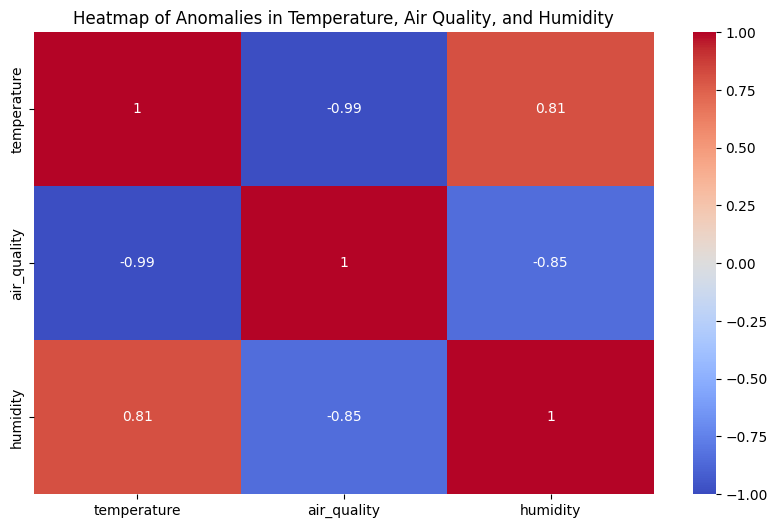

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the DataFrame for the heatmap based on provided data
environment_data = {
    'temperature': [33.3, 27.3, 27.3, 27.6, 27.3, 27.6],
    'air_quality': [55.1, 71.7, 73.3, 70.0, 71.2, 70.1],
    'humidity': [46.0, 29.0, 30.0, 39.0, 30.0, 38.0]
}

anomalies_df = pd.DataFrame(environment_data)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(anomalies_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Anomalies in Temperature, Air Quality, and Humidity')
plt.show()